# Débruitage d’image

### Modèle avec Recui simulé

In [1]:
import time
from IPython.display import clear_output
import numpy as np # import du package 'numpy' avec alias 'np'
import PIL.Image as pim # import du module 'Image' du package 'Pillow' avec alias 'pim'
import matplotlib.pyplot as plt

def view(image, mode=None, clamp=None, file=None, scale=1):
    """Display image with optional image conversion, clamping, or resizing
    - image:(numpy array or PIL image) = image to display
    - mode:str = PIL image mode = '1'|'L'|'P'|'RGB'|'LA'|'RGBA'
    - clamp:tuple = clamping range for channels = (min, max)
    - file:str = filename for saving on disk
    - scale:float = scale factor to resize the image (default = 1)"""
    import numpy as np
    from PIL import Image as pim
    from IPython.display import display

    assert isinstance(image, (np.ndarray, pim.Image)), 'wrong data for image'
    assert isinstance(clamp, (type(None), tuple)), 'wrong range for clamping'
    if isinstance(image, pim.Image): 
        image = np.array(image.convert('RGB') if image.mode == 'P' else image)
    elif image.ndim == 3 and image.shape[2] == 1: 
        image = image[:, :, 0]  # convert to 'L' mode
    if not clamp: 
        hi = image.max()
        clamp = (0, hi if hi else 1)
    lo, hi = clamp
    image = (np.clip(image, lo, hi) - lo) / (hi - lo) * 255
    image = pim.fromarray(image.astype('u1'))
    if mode: 
        image = image.convert(mode)  # optional: convert image to provided 'mode'
    if scale != 1:
        width, height = image.size
        new_size = (int(width * scale), int(height * scale))
        image = image.resize(new_size, pim.Resampling.NEAREST)  # Resize with scaling
    if file: 
        image.save(file)  # optional: save image to provided 'file'
    display(image)

width: 50, height: 50
[255 254 253 253 255 249 255 255 255 254   2   0   2   2   0 255 254 255
 253 255   3   1   1   0   0   2   2   0   0   1   0   1   0 248 255 252
 252 255 255 255 255 255 255 255 255 255 255 255 255 255]


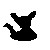

In [2]:
img = pim.open('images/immonde3.jpg') # lecture du fichier 'tiger.jpg' (mode = 'RGB') en taille 640*480
W, H = img.size

print(f"width: {W}, height: {H}")
#img.mode

image = np.array(img)[:,:,0]
print(image[30])
image = image.astype(np.int16)


view(image)

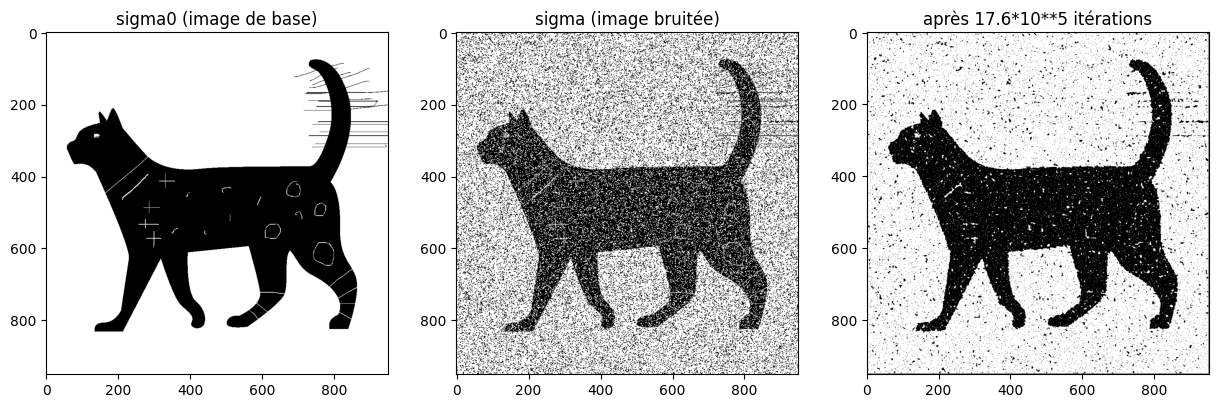

KeyboardInterrupt: 

In [6]:
# modèle basique 

img = pim.open('images/scary.jpg') # lecture du fichier 'tiger.jpg' (mode = 'RGB') en taille 640*480
W, H = img.size

image = np.array(img)[:,:,0]
image = image.astype(np.int16)


 
import numpy as np
import matplotlib.pyplot as plt

n = 10**7 # nombre d'itérations
alpha = 1/4
beta = 3/4
N = W # taille de l'image
p = 0.2 # probabilité de bruit

#view(image)

# -1 en blanc et 1 en noir

for i in range(N):
    for j in range(N):
        if image[i, j] > 200:
            image[i, j] = 1
        else:
            image[i, j] = -1

#print(image[30])

sigma0 = image
# Prendre des carrés de 4x4 pour bruiter l'image
bruit = np.ones((N, N))
for i in range(0, N, 2):
    for j in range(0, N, 2):
        if np.random.rand() < p:
            bruit[i:i+2, j:j+2] = -1

sigma = sigma0 * bruit

Saux = np.zeros((N+3, N+3)) # on rajoute des bords pour éviter les problèmes de voisins
Saux[1:N+1, 1:N+1] = sigma # on remplit la matrice auxiliaire avec sigma
sigmaaux = Saux.copy()

Energie = []
X = []

for q in range(1, n+1):
    T = 1/q # température (elle diminue pour atteindre la configuration stable)
    k = np.random.randint(1, N+1)
    l = np.random.randint(1, N+1)

    #s = Saux[k-1, l] + Saux[k+1, l] + Saux[k, l-1] + Saux[k, l+1] # somme des pixels voisins
    #s = Saux[k-1, l] + Saux[k+1, l] + Saux[k+1, l+1] + Saux[k+1, l-1] + Saux[k, l-1] + Saux[k, l+1] + Saux[k-1, l+1] + Saux[k-1, l-1] 
    s = Saux[k-1, l] + Saux[k+1, l] + Saux[k+1, l+1] + Saux[k+1, l-1] + Saux[k, l-1] + Saux[k, l+1] + Saux[k-1, l+1] + Saux[k-1, l-1] + Saux[k, l-2] + Saux[k, l+2] + Saux[k-1, l-1] + Saux[k-2, l] + Saux[k+2, l]  

    r = np.exp(-2 * Saux[k, l] * (2 * alpha * sigmaaux[k, l] + beta * s) / T) # probabilité de changer de signe (application de la formule de Metropolis)

    #if q%100 == 0: # on stocke l'énergie tous les 100 pas
        #E = - alpha * np.sum(sigmaaux * Saux) - beta * np.sum(Saux[1:N+1, 1:N+1] * (Saux[0:N, 1:N+1] + Saux[2:N+2, 1:N+1] + Saux[1:N+1, 0:N] + Saux[1:N+1, 2:N+2]))
        #Energie.append(E)
        #
        #X.append(q)

    if q%220000 == 0: 
    #if q%100000 == 0: 
        clear_output(wait=True)
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        axs[0].imshow(sigma0, cmap='gray')
        axs[0].set_title('sigma0 (image de base)')
        axs[1].imshow(sigma, cmap='gray')
        axs[1].set_title('sigma (image bruitée)')
        axs[2].imshow(Saux, cmap='gray')
        axs[2].set_title(f'après {q/100000}*10**5 itérations')
        plt.show()
    
    if np.random.rand() < r: # on change de signe si la probabilité est inférieure à r
        Saux[k, l] = -Saux[k, l]

S = Saux[1:N+1, 1:N+1] # résultat final


clear_output(wait=True)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(sigma0, cmap='gray')
axs[0].set_title('sigma0 (image de base)')
axs[1].imshow(sigma, cmap='gray')
axs[1].set_title('sigma (image bruitée)')
axs[2].imshow(S, cmap='gray')
axs[2].set_title('S (image finale)')

plt.show()

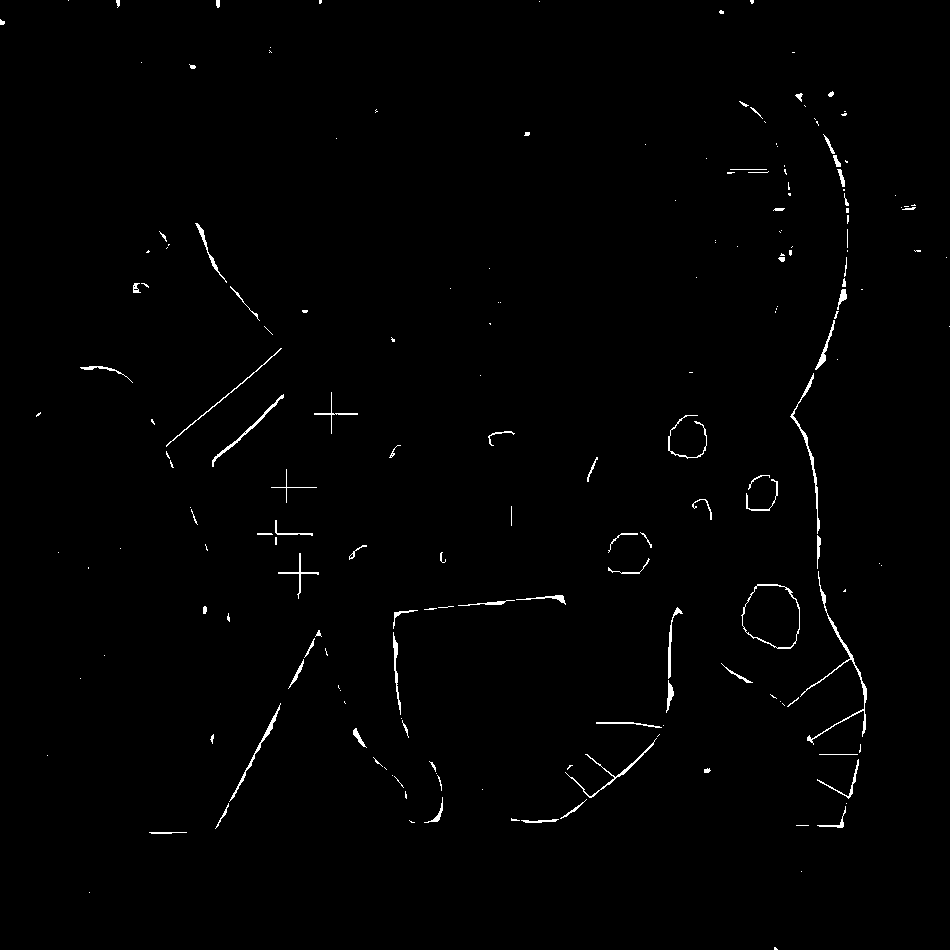

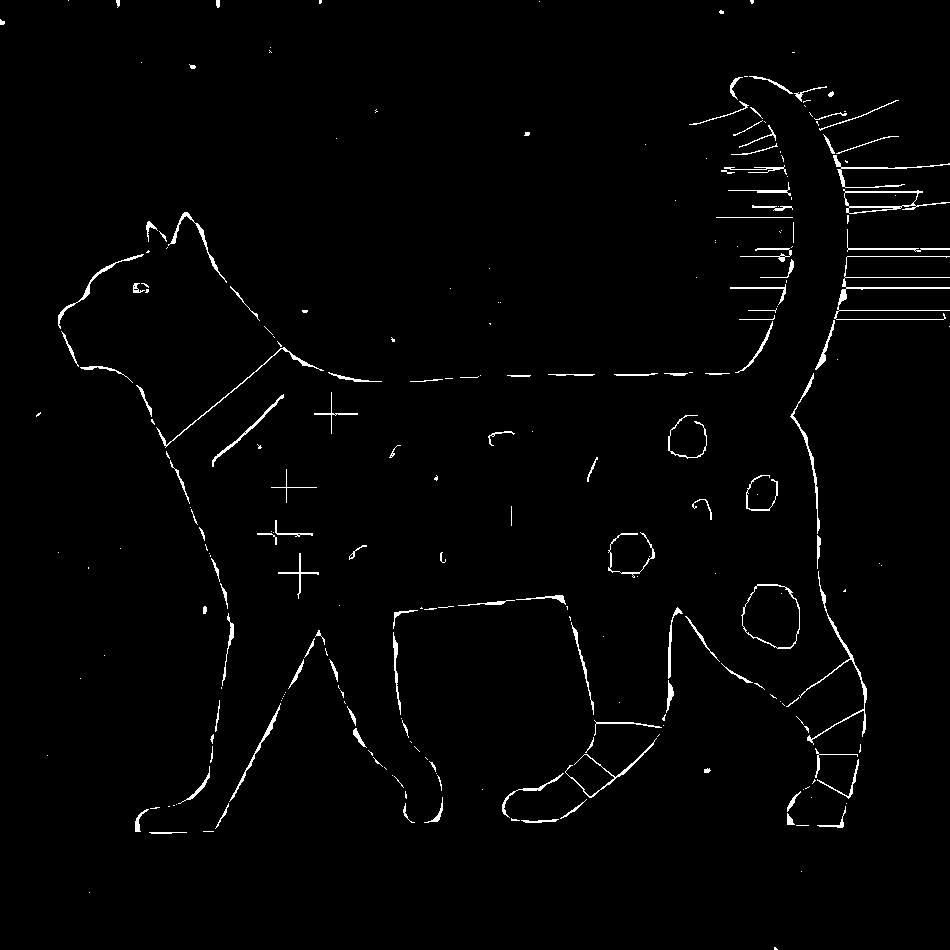

In [9]:
diff = sigma0 - S
view(diff)

abs = np.abs(diff)//2
view(abs)

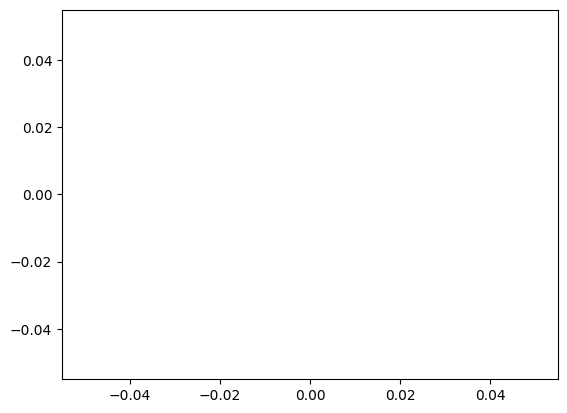

In [10]:
plt.plot(X, Energie)